In [1]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
library_path = '/Users/salvatoreesposito/Desktop/peakonly'
sys.path.append(library_path)
from models.cnn_classifier import Classifier
from models.cnn_segmentator import Segmentator
from processing_utils.roi import ROI

%load_ext autoreload
%autoreload 2

In [2]:
# checking if gpu is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
# importing the pre-trained CNN classifier and loading weights
# the convolutional neural network is defined
classifier = Classifier().to(device)
path2classifier_weights = os.path.join(library_path,'data', 'weights', 'Classifier.pt')
classifier.load_state_dict(torch.load(path2classifier_weights, map_location=device))
classifier.eval()


Classifier(
  (convBlock): Sequential(
    (0): Block(
      (basic_block): Sequential(
        (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
      )
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Block(
      (basic_block): Sequential(
        (0): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
      )
    )
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Block(
      (basic_block): Sequential(
        (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
      )
    )
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Block(
      (basic_block): Sequential(
        (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
      )
    )
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [4]:
# the second pre trained CNN for peak integration is imported and the weights loaded 
segmentator = Segmentator().to(device)
path2segmentator_weights = os.path.join(library_path, 'data', 'weights', 'Segmentator.pt')
segmentator.load_state_dict(torch.load(path2segmentator_weights, map_location=device))
segmentator.eval()

Segmentator(
  (starter): Sequential(
    (0): Block(
      (basic_block): Sequential(
        (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Block(
      (basic_block): Sequential(
        (0): Conv1d(16, 20, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (3): Block(
      (basic_block): Sequential(
        (0): Conv1d(20, 24, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (5): Block(
      (basic_block): Sequential(
        (0): Conv1d(24, 28, kernel_size

In [5]:
mzml_filepath = "/Users/salvatoreesposito/Downloads/peakonly-master/data/annotation/Dataset"

In [6]:
import json
import time
from Main import peakonly
from os import listdir
from os.path import isfile, join, isdir
start = time.time()
# firstly we access the directory to look for the file path
directories = [f for f in listdir(mzml_filepath) if isdir(join(mzml_filepath, f))]
for dir in directories:
    dir = mzml_filepath + "/" + dir
    onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))]
    rois = []
    # open files in the directory which are json files
    for files in onlyfiles:
        with open(dir + "/" + files) as json_file:
            # we use a try and catch as there are hidden files
            try:
                data = json.load(json_file)
            except: 
                continue
            num_peaks = data["number of peaks"]
            # get only the files where the number of peaks is = 1
        if num_peaks == 1:
            rois += peakonly(onlyfiles)
# get the time for the CNN to process Rois, continued in the function below
end = time.time()
print(end - start)



0
.DS_Store
0
0
0
2
0
1
0
0
0
3.74137282371521


In [7]:
from processing_utils.run_utils import preprocess, correct_classification, get_borders, Feature
from Main import sub_rois
from roi import ROI as poROI
import time
import csv
# get the rois as sub rois from the main
start = time.time()
split_rois=[]
for idx, roi in enumerate(rois):
    # get the rois which have at least 5 scans
    if roi.peak_list[-1].scan - roi.peak_list[0].scan >= 5:
        # create a file and write the first results
        with open("Results/CNN_roi_" + str (idx) + ".csv", 'w') as file:
            percentage = 10
            split_rois = sub_rois(roi,percentage)
            file.write("percentage,result,mz,rt,scan,max_intensity" + "\n")
            # this method converts the sub_rois into the peakonly roi objects
            for i in range(len(split_rois)-1):
                rr = poROI([split_rois[i].peak_list[0].scan,split_rois[i].peak_list[-1].scan],
                        [split_rois[i].peak_list[0].rt,split_rois[i].peak_list[-1].rt],
                        [p.i for p in split_rois[i].peak_list],
                        [split_rois[i].peak_list[0].mz,split_rois[i].peak_list[-1].mz],split_rois[i].mean_mz)
                        # pass the signal which is a list of intensitites to the cnn and interpolate it
                signal = preprocess(rr.i, torch.device('cpu'), interpolate=True,length=256)
                classifier_output, _ = classifier(signal)
                _, segmentator_output = segmentator(signal)
                classifier_output = classifier_output.data.cpu().numpy()
                # label is the initial output of the cnn
                label = np.argmax(classifier_output)
                result = label
                # write the output as 0 for non peaks and 1 for classified peaks
                if result > 0.5:
                    result = 1
                else: 
                    result = 0
                file.write(str(i*percentage + percentage) + "," + str(result)+ "," + str(np.array(rr.mz))+ "," + str(np.array(rr.rt)) + "," + str(np.array(rr.scan)) + "," + str(np.max(rr.i)) + "\n")


end = time.time()
print(end - start)

237.07401084899902


In [9]:
from os import listdir
import statistics
from os.path import isfile, join, isdir
import numpy as np
import csv
import pandas as pd
# open results to start the final statistics 
onlyfiles = [f for f in listdir("Results") if isfile(join("Results", f))]
rois = []
percentages = []
intensities = []
mz = []
rt = []
cnn_percentage = []
num_rois = 0
num_classified_rois = 0
# loop over the files and append the final percentage and result
for files in onlyfiles:
    findpercentage = False
    file_name = files
    with open("Results/"+files, 'r') as file:
        next(file)
        for line in file:
            line = line.split(",")
            if line[1].strip()== str (1):
                percentage = line[0].strip()
                result = line[1].strip()
                # only append the percentage correlated to the result that has been classified as 1
                if (int(result)) == 1 and not findpercentage:
                    cnn_percentage.append(int(percentage))
                    findpercentage = True
                    print(cnn_percentage)
                    # because of double arrays use split and the one value out of the mz, rt
                intensity = line[5].strip()
                percentages.append(line[0])
                mzstart = line[2].split()[0]
                mzend = line[2].split()[1]
                mzstart = mzstart.replace("[","")
                mzend= mzend.replace("]","")
                mzvalue = statistics.mean([float(mzstart), float(mzend)])
                mz.append(mzvalue)
                rt_start = line[3].split()[0]
                rt_end = line[3].split()[1]
                rt_start = rt_start.replace("[","")
                rt_end= rt_end.replace("]","")
                rtvalue = statistics.mean([float(rt_start), float(rt_end)])
                rt.append(rtvalue)
                num_classified_rois += 1
                intensity = float(intensity.replace("\n",""))
                intensities.append(intensity)
            num_rois += 1
            # calculate the mean of these values
mean_mz = statistics.mean(mz)
mean_rt = statistics.mean(rt)
intensity = statistics.mean(intensities)
percent = statistics.mean(cnn_percentage)

with open('Final_mean_results.csv', 'w', newline='') as csvfile: 
    meanwriter = csv.writer(csvfile, delimiter=' ',quotechar='|',quoting=csv.QUOTE_MINIMAL)
    meanwriter.writerow(["cnn_value_count","classified_rois","mean_mz","mean_rt","mean_max_intensity"])
    meanwriter.writerow([pd.Series(cnn_percentage).value_counts(),str(num_classified_rois/num_rois),mean_mz,mean_rt, intensity])

bar_data = pd.Series(cnn_percentage).value_counts()


00, 100, 60, 90, 30, 30, 30, 90, 10, 80, 30, 30, 90, 90, 100, 60, 70, 20, 20, 30, 100, 50, 80, 90, 10, 60, 70, 100, 60, 60, 30, 20, 80, 60, 70, 10, 40, 70, 70, 90, 80, 20, 80, 50, 30, 40, 60, 40, 100, 90, 30, 20, 80, 90, 80, 30, 60, 90, 100, 30, 30, 100, 80, 80, 30, 90, 30, 40, 80, 30, 100, 60, 80, 90, 50, 100, 100, 50, 90, 70, 70, 100, 20, 40, 100, 100, 60, 90, 60, 40, 60, 20, 90, 90, 50, 50, 100, 80, 100, 90, 90, 80, 100, 50, 100, 90, 40, 60, 60, 30, 90, 90, 40, 30, 40, 70, 100, 90, 100, 60, 100, 30, 30, 40, 80, 50, 90, 60, 40, 80, 20, 70, 70, 30, 80, 100, 50, 40]
[90, 50, 90, 30, 90, 50, 60, 30, 90, 30, 90, 90, 50, 50, 30, 50, 50, 90, 70, 50, 50, 40, 60, 70, 50, 20, 30, 90, 30, 100, 60, 90, 50, 100, 90, 20, 50, 70, 80, 30, 100, 50, 50, 70, 100, 60, 20, 30, 70, 90, 80, 70, 80, 60, 100, 30, 60, 80, 60, 50, 80, 50, 100, 60, 50, 90, 10, 100, 30, 80, 20, 80, 10, 50, 60, 60, 60, 90, 20, 60, 80, 40, 60, 50, 60, 90, 80, 90, 60, 100, 80, 30, 60, 40, 50, 30, 50, 30, 20, 100, 100, 60, 90, 30, 

Int64Index([90, 100, 30, 60, 80, 50, 70, 20, 40, 10], dtype='int64')
0
90     41
100    35
30     35
60     32
80     29
50     29
70     17
20     17
40     16
10      5
0       0
dtype: int64


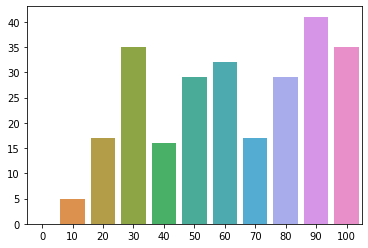

In [10]:
# plot the percentage interval against the count of classified rois
import seaborn as sns
import matplotlib.pyplot as plt
print(bar_data.index)
for i in range(0,101,10):
    if i not in bar_data.index:
        print(i)
        bar_data.at[i]=0
print(bar_data)
sns.barplot(x=bar_data.index, y= bar_data.values)


In [27]:
from processing_utils.run_utils import preprocess, correct_classification, get_borders, Feature
def cnn (rr):
    lvals = np.arange(10,100,2)
    lf = []
    print(lvals)
    pp = []
    for lval in lvals:
        signal = preprocess(rr.i[:lval], torch.device('cpu'), interpolate=True,length=256)
        classifier_output, _ = classifier(signal)
        _, segmentator_output = segmentator(signal)

        classifier_output = classifier_output.data.cpu().numpy()
        label = np.argmax(classifier_output)
        pp.append(classifier_output[0][1])

        borders = get_borders(segmentator_output[0, 0, :], segmentator_output[0, 1, :],
                            peak_minimum_points=8,
                            interpolation_factor=len(signal[0, 0]) / len(rr.i))
        features = []
        for border in borders:
            # to do: check correctness of rt calculations
            scan_frequency = (rr.scan[1] - rr.scan[0]) / (rr.rt[1] - rr.rt[0])
            rtmin = rr.rt[0] + border[0] / scan_frequency
            rtmax = rr.rt[0] + border[1] / scan_frequency
            feature = Feature(["AAA"], [roi], [border], [0], [np.sum(rr.i[border[0]:border[1]])],
                            rr.mzmean, rtmin, rtmax, 0, 0)
            features.append(feature)
        lf.append(len(features))

        # plt.plot(lvals,lf,label='ispeak')
        # plt.plot(lvals,1/(1+np.exp(-np.array(pp))),label='probability')
        # plt.plot(range(len(rr.i)),rr.i/max(rr.i),label='signal')
        # plt.legend()
        # plt.savefig('/Users/salvatoreesposito/Desktop/ROIdetection/shit_roi_idx10.png')

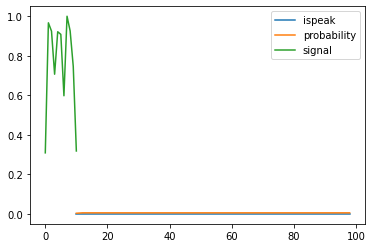

In [23]:
plt.plot(lvals,lf,label='ispeak')
plt.plot(lvals,1/(1+np.exp(-np.array(pp))),label='probability')
plt.plot(range(len(rr.i)),rr.i/max(rr.i),label='signal')
plt.legend()
plt.savefig('/Users/salvatoreesposito/Desktop/ROIdetection/shit_roi_idx10.png')